# Churn Model

In [531]:
import torch
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [515]:
dataset = pd.read_csv('Churn_Modelling.csv')
X = dataset.iloc[:, 3:-1].values
y = dataset.iloc[:, -1].values
dataset

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


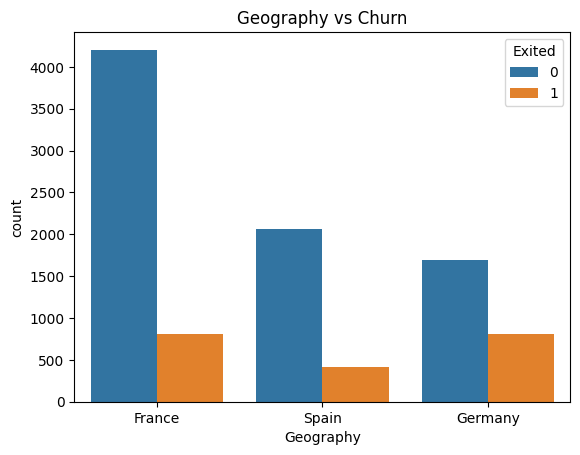

In [537]:
sns.countplot(data=dataset, x='Geography', hue='Exited')
plt.title("Geography vs Churn")
plt.show()

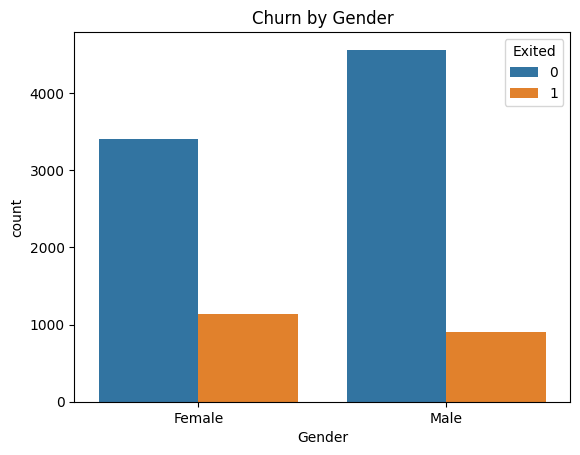

In [538]:
sns.countplot(x="Gender", hue="Exited", data=dataset)
plt.title("Churn by Gender")
plt.show()

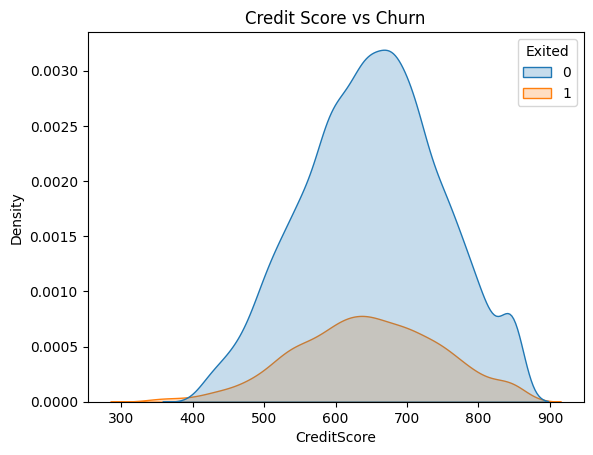

In [542]:
sns.kdeplot(data=dataset, x="CreditScore", hue="Exited", fill=True)
plt.title("Credit Score vs Churn")
plt.show()

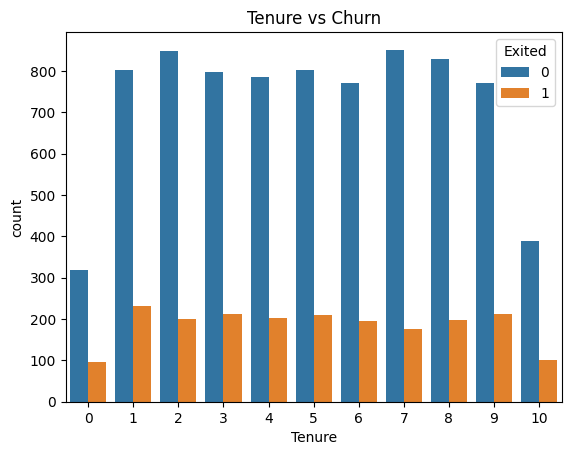

In [543]:
sns.countplot(x="Tenure", hue="Exited", data=dataset)
plt.title("Tenure vs Churn")
plt.show()

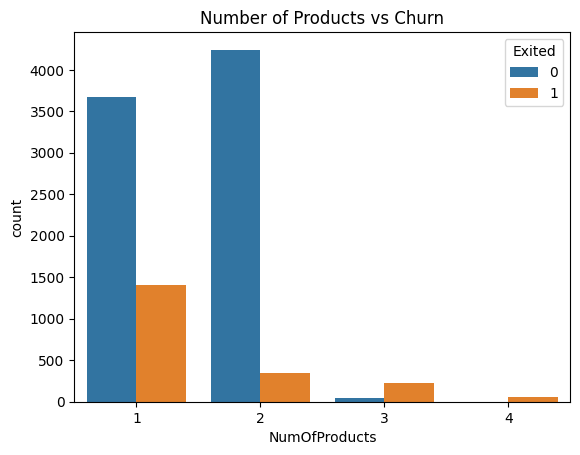

In [544]:
sns.countplot(x="NumOfProducts", hue="Exited", data=dataset)
plt.title("Number of Products vs Churn")
plt.show()

In [516]:
le = LabelEncoder()
X[:, 2] = le.fit_transform(X[:, 2])
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [517]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [518]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train.dtype

dtype('float64')

In [519]:
X_train = torch.tensor(X_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)

# Building a model

In [520]:
class ChurnModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 12,
                             out_features = 32)
    self.batchnorm1 = nn.BatchNorm1d(num_features=32)
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(p = 0.1)

    self.layer_2 = nn.Linear(in_features = 32,
                             out_features = 32)
    self.batchnorm2 = nn.BatchNorm1d(num_features=32)
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(p = 0.1)

    self.layer_3 = nn.Linear(in_features = 32,
                             out_features = 32)
    self.batchnorm3 = nn.BatchNorm1d(num_features=32)
    self.relu3 = nn.ReLU()
    self.dropout3 = nn.Dropout(p = 0.1)

    self.layer_4 = nn.Linear(in_features = 32,
                             out_features = 1)

  def forward(self, x):
    x = self.layer_1(x)
    x = self.batchnorm1(x)
    x = self.relu1(x)
    x = self.dropout1(x)

    x = self.layer_2(x)
    x = self.batchnorm2(x)
    x = self.relu2(x)
    x = self.dropout2(x)

    x = self.layer_3(x)
    x = self.batchnorm3(x)
    x = self.relu3(x)
    x = self.dropout3(x)

    x = self.layer_4(x)
    return x

In [521]:
model = ChurnModel()

In [522]:
with torch.inference_mode():
  y_preds = model(X_test)
  y_pred_probs = torch.sigmoid(y_preds)
  y_labels = torch.round(y_pred_probs)

acc = accuracy_score(y_test, y_preds.numpy().astype(int))
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.7715


In [523]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [524]:
torch.manual_seed(42)
epochs = 300

for epoch in range(epochs):
  model.train()

  y_logits = model(X_train)
  y_pred_probs = torch.sigmoid(y_logits)
  y_labels = torch.round(y_pred_probs)


  loss = loss_fn(y_logits, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_pred_probs = torch.sigmoid(test_logits)
    test_labels = torch.round(test_pred_probs)

    test_loss = loss_fn(test_logits, y_test)
  if epoch % 10 == 0:
    print(f"Epoch : {epoch} | Train Loss : {loss:.4f} | Test Loss : {test_loss:.4f}")

Epoch : 0 | Train Loss : 0.6554 | Test Loss : 0.6674
Epoch : 10 | Train Loss : 0.5760 | Test Loss : 0.6404
Epoch : 20 | Train Loss : 0.5281 | Test Loss : 0.5775
Epoch : 30 | Train Loss : 0.4893 | Test Loss : 0.5209
Epoch : 40 | Train Loss : 0.4589 | Test Loss : 0.4809
Epoch : 50 | Train Loss : 0.4422 | Test Loss : 0.4502
Epoch : 60 | Train Loss : 0.4259 | Test Loss : 0.4248
Epoch : 70 | Train Loss : 0.4109 | Test Loss : 0.4066
Epoch : 80 | Train Loss : 0.3984 | Test Loss : 0.3923
Epoch : 90 | Train Loss : 0.3890 | Test Loss : 0.3806
Epoch : 100 | Train Loss : 0.3807 | Test Loss : 0.3706
Epoch : 110 | Train Loss : 0.3763 | Test Loss : 0.3620
Epoch : 120 | Train Loss : 0.3679 | Test Loss : 0.3552
Epoch : 130 | Train Loss : 0.3612 | Test Loss : 0.3504
Epoch : 140 | Train Loss : 0.3574 | Test Loss : 0.3459
Epoch : 150 | Train Loss : 0.3571 | Test Loss : 0.3418
Epoch : 160 | Train Loss : 0.3537 | Test Loss : 0.3391
Epoch : 170 | Train Loss : 0.3503 | Test Loss : 0.3375
Epoch : 180 | Train L

# Final accuracy

In [525]:
with torch.inference_mode():
  test_logits = model(X_test)
  test_pred_probs = torch.sigmoid(test_logits)
  test_labels = torch.round(test_pred_probs)

print(f"Final Test Accuracy : {accuracy_score(test_labels.squeeze(), y_test) * 100} %")
cm = confusion_matrix(test_labels.squeeze(), y_test)
print(f"Confusion matrix : \n{cm}")

Final Test Accuracy : 86.45 %
Confusion matrix : 
[[1518  194]
 [  77  211]]


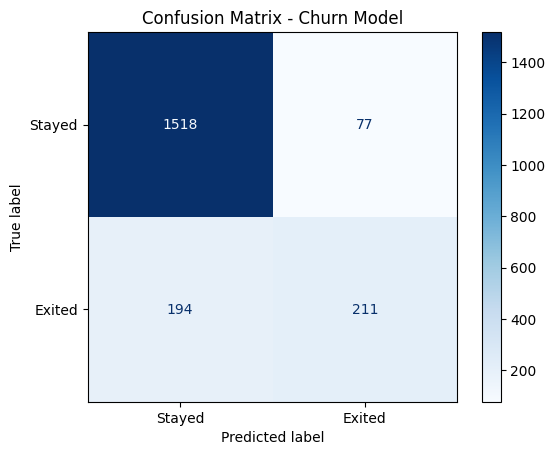

In [533]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Stayed", "Exited"])
# Plot
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Churn Model")
plt.show()